In [1]:
# You will need a us census API key stored securely to run the census functions.

us_census_api_key = ''

# Software versions after last run

# Python version: 3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]
# GeoPandas version: 0.14.2
# matplotlib version:  3.8.0
# Pandas version: 2.2.1
# Numpy version:  1.26.4
# Shapely version:  2.0.1

In [2]:
import fiona

In [3]:
%matplotlib inline

from datetime import datetime

# Force GeoPandas pre version 0.14 to use Shapely by default instead of PyGEOS
import os
os.environ['USE_PYGEOS'] = '0'

import sys
print("Python version:", sys.version)

import geopandas as gp
print("GeoPandas version:", gp.__version__)
import matplotlib
print("matplotlib version: ", matplotlib.__version__)
import matplotlib.pyplot as plt
import pandas as pd
print("Pandas version:", pd.__version__)
import numpy as np
print("Numpy version: ", np.__version__)

import shapely
from shapely import wkt
print("Shapely version: ", shapely.__version__)
from shapely.geometry import Point, Polygon, MultiPolygon

from scipy.spatial import cKDTree

import networkx as nx
print("NetworkX version: ", nx.__version__)

import osmnx as ox
print("OSMNX version: ", ox.__version__)
import os
from stat import S_ISDIR

#ox.settings.use_cache = True
from adjustText import adjust_text


Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
GeoPandas version: 0.14.3
matplotlib version:  3.8.0
Pandas version: 2.2.1
Numpy version:  1.26.4
Shapely version:  2.0.2
NetworkX version:  3.1
OSMNX version:  1.9.2


In [6]:
data_loc = "../../DATA/"
gitrepo_data_loc = "../DATA/"
secrets_loc = "./.secrets/"

In [7]:
def make_gdf(data_df):
    if 'geometry' in data_df.columns:
        data_df['geometry'] = data_df['geometry'].apply(wkt.loads)
        return gp.GeoDataFrame(data_df, crs='epsg:4326')
    else:
        data_df.columns = data_df.columns.str.lower()
        geo_df = gp.GeoDataFrame(
            data_df, crs=4326, geometry=gp.points_from_xy(data_df.longitude, data_df.latitude))
        return geo_df

In [4]:

def nearestpoint(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat([gdA.reset_index(drop=True), gdB_nearest, pd.Series(dist, name='dist')], axis=1)
    return gdf




In [8]:
#open MI Puplic Land Survey Sections
eup_sections = gp.read_file(data_loc + 'MI/Sections-Counties-17-48-49/Public_Land_Survey_Sections.shp')

#open MI Public Land Survey Quarter Qaarter Sections
eup_qq_sections = gp.read_file(data_loc + 'MI/QQSections-Counties-17-48-49/Public_Land_Survey_Quarter-Quarter_Sections.shp')

In [9]:
eup_qq_sections.geometry

0        POLYGON ((-84.98570 46.78241, -84.98576 46.778...
1        POLYGON ((-84.98065 46.78228, -84.98074 46.778...
2        POLYGON ((-84.99092 46.78239, -84.99098 46.778...
3        POLYGON ((-84.97538 46.78214, -84.97547 46.778...
4        POLYGON ((-84.99613 46.78236, -84.99619 46.778...
                               ...                        
60696    POLYGON ((-84.44647 45.74867, -84.44664 45.748...
60697    POLYGON ((-84.43258 45.74606, -84.43140 45.745...
60698    POLYGON ((-84.47276 45.74323, -84.47290 45.742...
60699    POLYGON ((-84.43140 45.74571, -84.43026 45.745...
60700    POLYGON ((-84.41621 45.73791, -84.40831 45.735...
Name: geometry, Length: 60701, dtype: geometry

In [13]:
BDC_Cable_gdf = make_gdf(pd.read_csv(gitrepo_data_loc + 'EUP_BDC_cable_fixed_jul23mar24.csv'))
BDC_Fiber_gdf = make_gdf(pd.read_csv(gitrepo_data_loc + 'EUP_BDC_fiber_fixed_jul23mar24.csv'))
BDC_Copper_gdf = make_gdf(pd.read_csv(gitrepo_data_loc + 'EUP_BDC_copper_fixed_jul23mar24.csv'))
USAC_Deployment_gdf = make_gdf(pd.read_csv(gitrepo_data_loc + 'EUP_USAC_Deployment-0923.csv'))
EUP_BSL_gdf = make_gdf(pd.read_csv(gitrepo_data_loc + 'EUP_BSL.csv'))

In [14]:
BDC_Cable_gdf = BDC_Cable_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]
BDC_Cable_gdf['technology_name'] = 'Cable'

In [15]:
BDC_Fiber_gdf = BDC_Fiber_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]

BDC_Fiber_gdf['technology_name'] = 'Fiber'

In [16]:
BDC_Copper_gdf = BDC_Copper_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]
BDC_Copper_gdf['technology_name'] = 'DSL'

In [17]:
BDC_Cable_gdf.columns

Index(['unit_count', 'bsl_flag', 'building_type_code', 'land_use_code', 'h3_9',
       'fcc_rel', 'frn', 'provider_id', 'brand_name', 'technology',
       'max_advertised_download_speed', 'max_advertised_upload_speed',
       'low_latency', 'business_residential_code', 'geometry',
       'technology_name'],
      dtype='object')

In [18]:
BDC_Fiber_gdf.columns

Index(['unit_count', 'bsl_flag', 'building_type_code', 'land_use_code', 'h3_9',
       'fcc_rel', 'frn', 'provider_id', 'brand_name', 'technology',
       'max_advertised_download_speed', 'max_advertised_upload_speed',
       'low_latency', 'business_residential_code', 'geometry',
       'technology_name'],
      dtype='object')

In [19]:
BDC_Copper_gdf['low_latency'] = 0

In [20]:
USAC_Deployment_gdf['Download/Upload Speed Tier'].unique()

array(['10 Mbps/1 Mbps', '100 Mbps/25 Mbps', '25 Mbps/3 Mbps',
       '4 Mbps/1 Mbps', '1 Gbps/500 Mbps'], dtype=object)

In [21]:
USAC_Deployment_gdf.columns

Index(['Unnamed: 0', 'Fund', 'Study Area Code', 'Company Name', 'Carrier',
       'Latitude', 'Longitude', 'Deployment Address', 'Deployment City',
       'Deployment State', 'Deployment ZIP Code', 'SAC Primary State',
       'Deployment Date', 'Filing Year', 'Census Block', 'Locations Deployed',
       'Download/Upload Speed Tier', 'Technology', 'Other Technology',
       'Latency', 'Overlapping Locations', 'FIPSCODE', 'geometry'],
      dtype='object')

<Axes: >

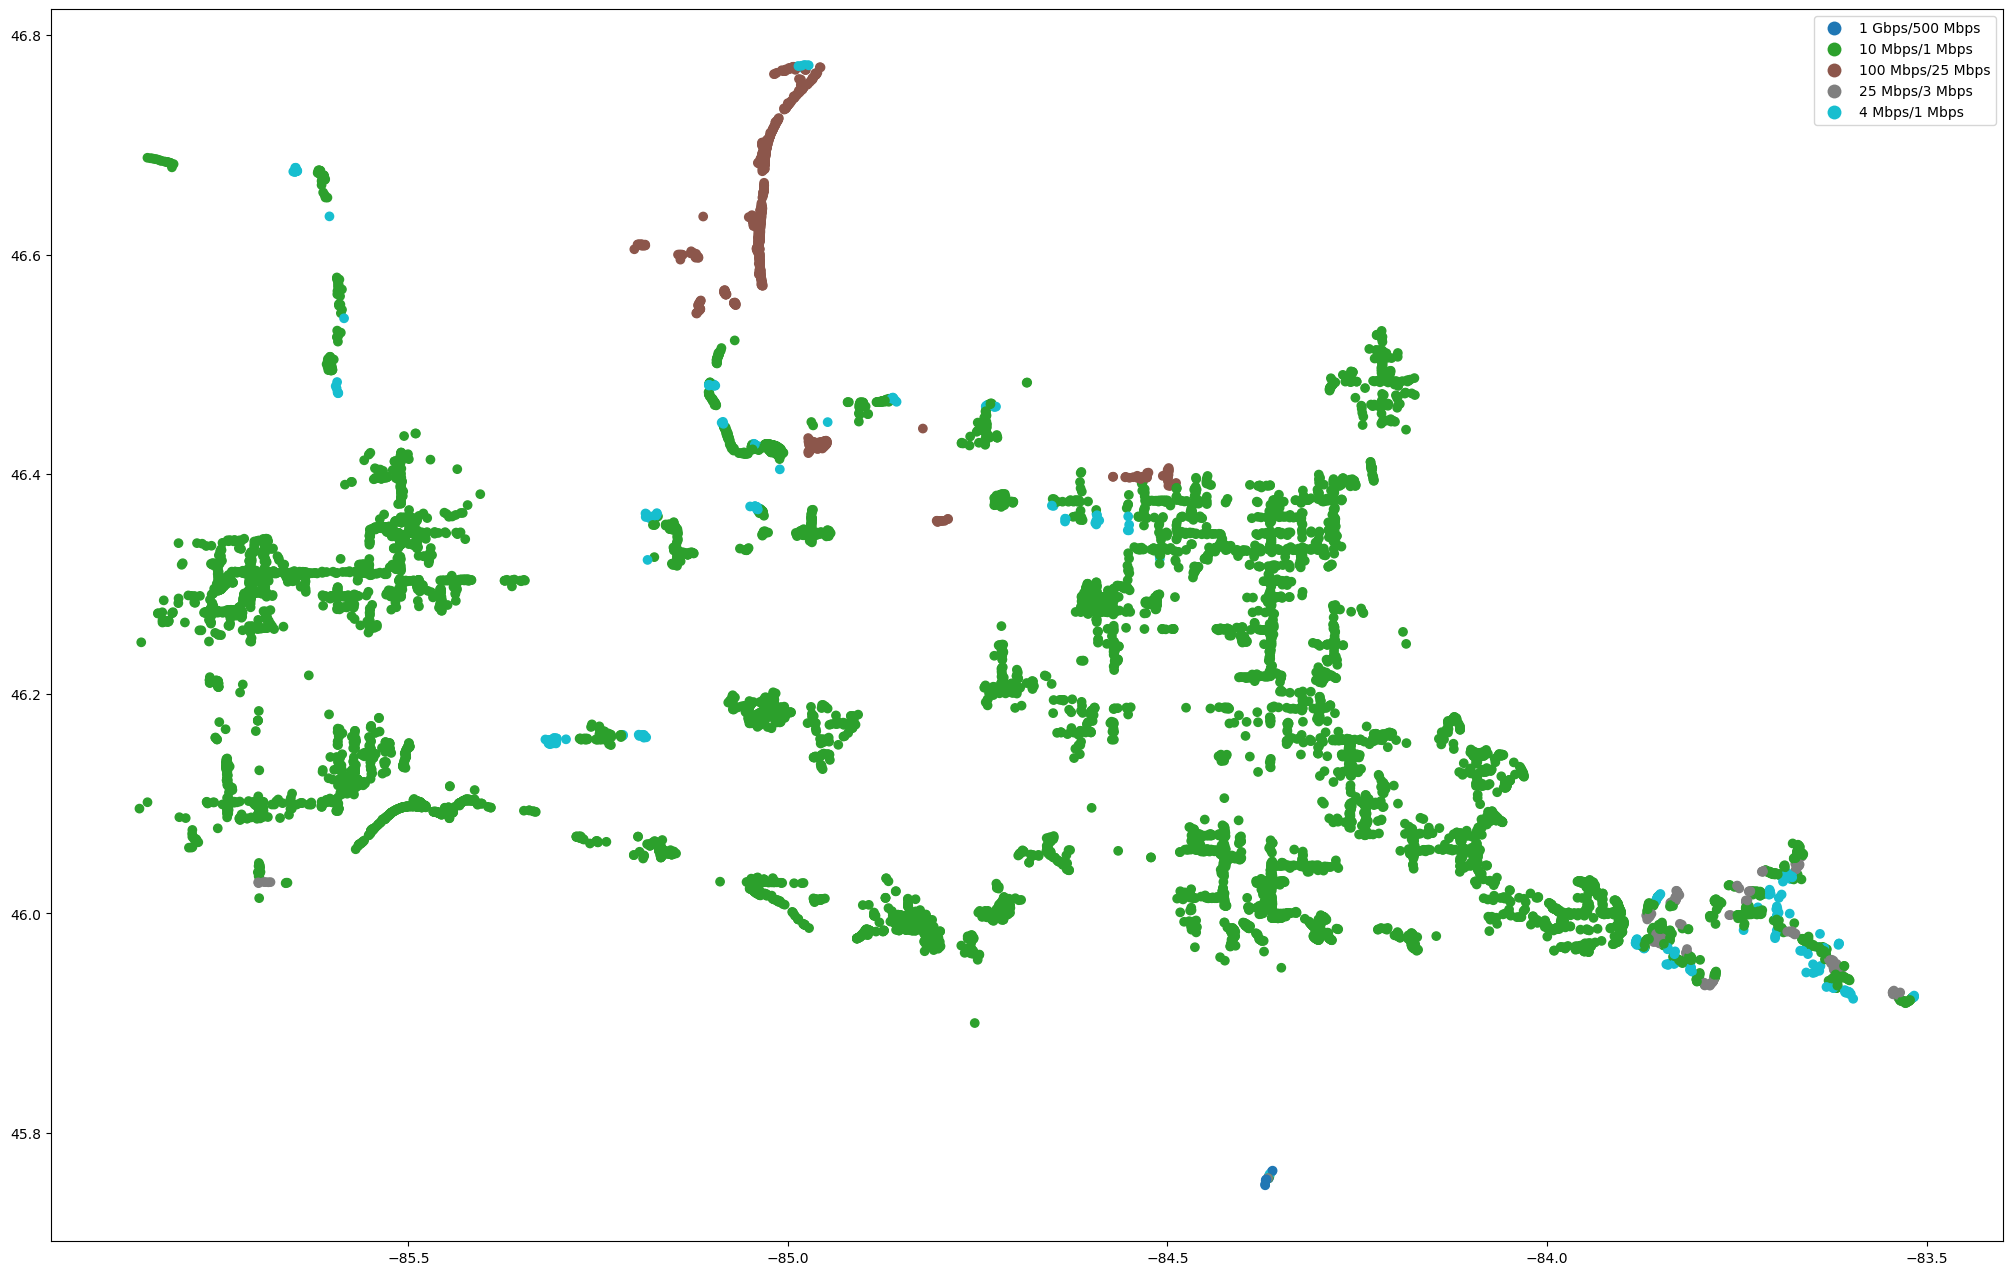

In [22]:
USAC_Deployment_gdf.plot(USAC_Deployment_gdf['Download/Upload Speed Tier'], figsize=(32,16), legend=True)

In [35]:
BDC_fixed_gdf = pd.concat([BDC_Cable_gdf, BDC_Fiber_gdf, BDC_Copper_gdf], ignore_index=True)
BDC_fixed_gdf = BDC_fixed_gdf[['building_type_code', 'land_use_code', 'provider_id', 'brand_name',
                               'technology', 'technology_name', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]

In [36]:
BDC_fixed_gdf['up_down_ratio'] = BDC_fixed_gdf['max_advertised_upload_speed'] / BDC_fixed_gdf['max_advertised_download_speed']

In [37]:
BDC_fixed_gdf['up_down_ratio']

0        0.035
1        0.035
2        0.035
3        0.035
4        0.035
         ...  
34385      NaN
34386    0.100
34387    0.100
34388    0.100
34389      NaN
Name: up_down_ratio, Length: 34390, dtype: float64

<Axes: >

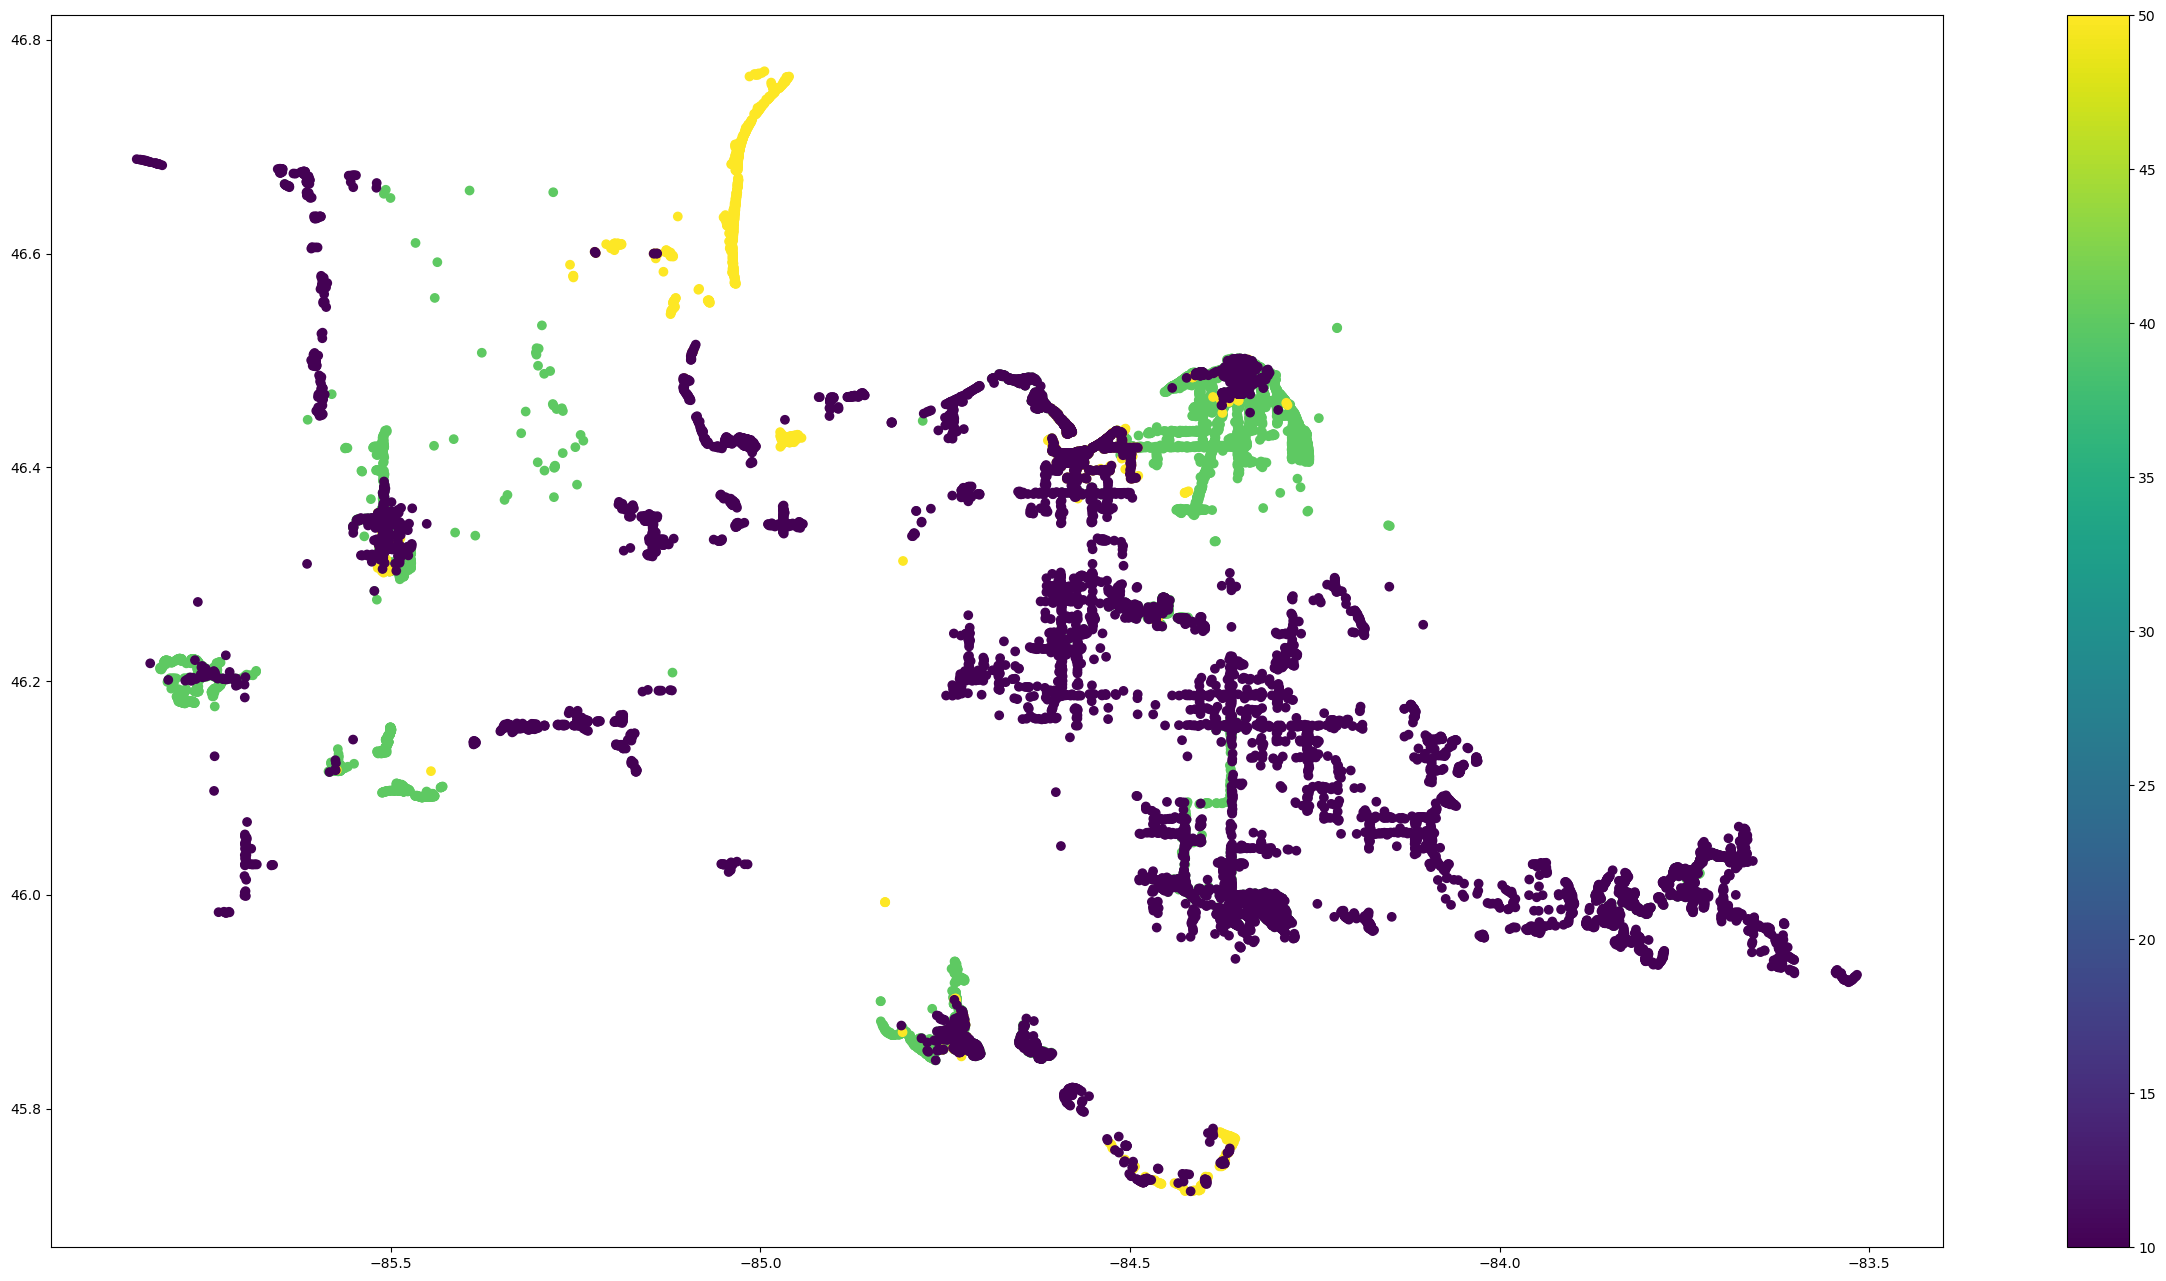

In [38]:
BDC_fixed_gdf.plot(BDC_fixed_gdf['technology'], figsize=(32,16), legend=True)

In [39]:
BDC_fixed_gdf.to_file(gitrepo_data_loc + 'BDC_fixed.gpkg', driver="GPKG", index=False)

In [40]:
BDC_fixed_gdf = gp.read_file(gitrepo_data_loc + 'BDC_fixed.gpkg')

In [41]:
BDC_fixed_gdf.columns

Index(['building_type_code', 'land_use_code', 'provider_id', 'brand_name',
       'technology', 'technology_name', 'max_advertised_download_speed',
       'max_advertised_upload_speed', 'low_latency',
       'business_residential_code', 'up_down_ratio', 'geometry'],
      dtype='object')

<Axes: >

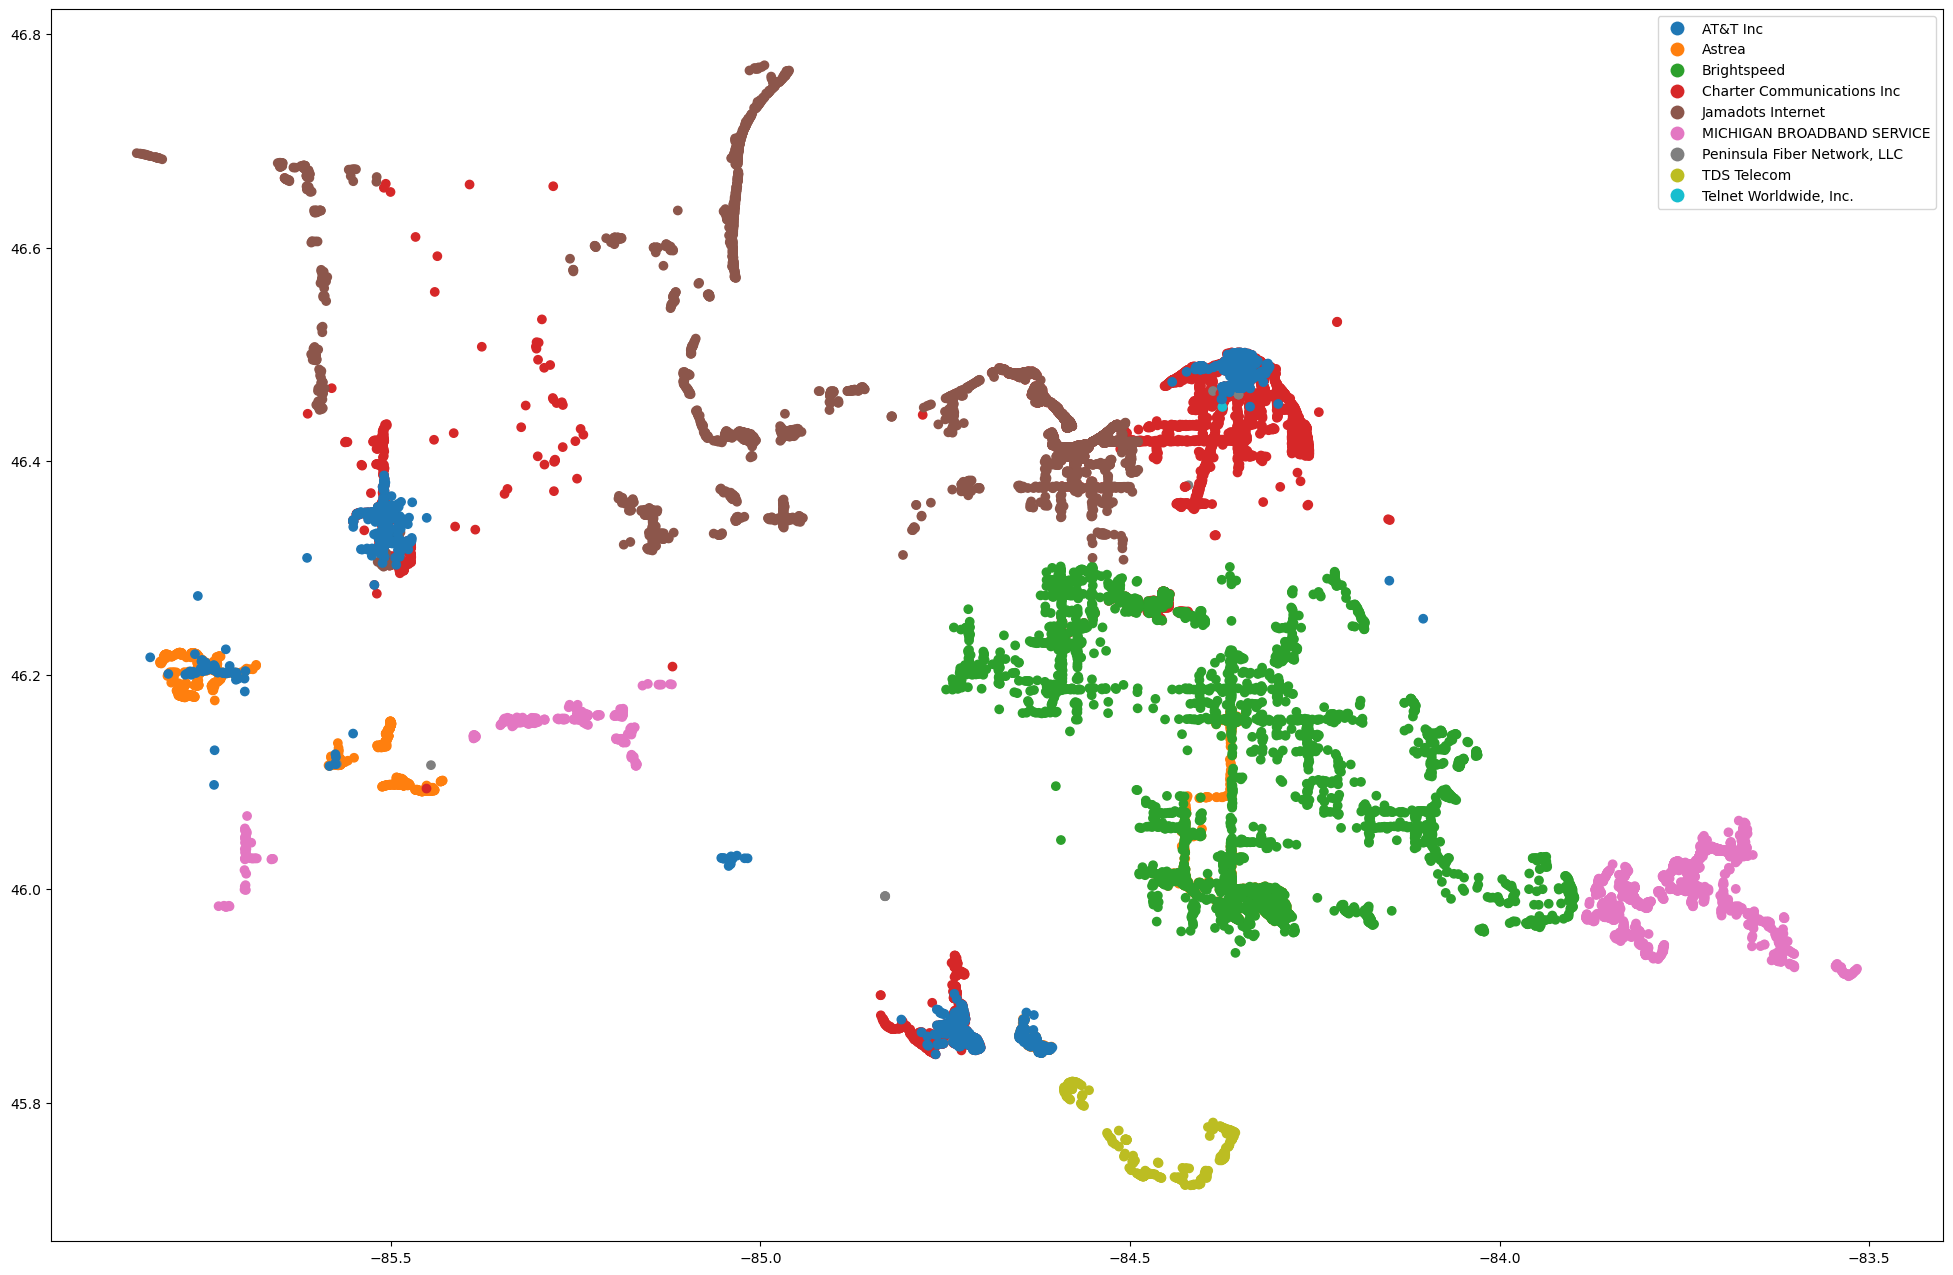

In [97]:
BDC_fixed_gdf.plot(BDC_fixed_gdf['brand_name'], figsize=(32,16), legend=True)

In [102]:
fiona.listlayers(gitrepo_data_loc + 'EUPOSMgraph.gpkg')

['nodes', 'edges']

In [103]:
EUP_Roads_gdf = gp.read_file(gitrepo_data_loc + 'EUPOSMgraph.gpkg', layer='edges')

<Axes: >

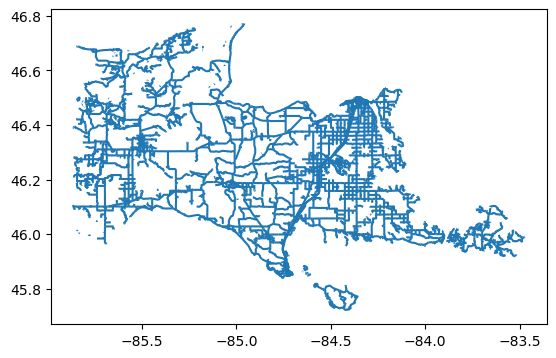

In [105]:
EUP_Roads_gdf.plot()

<Axes: >

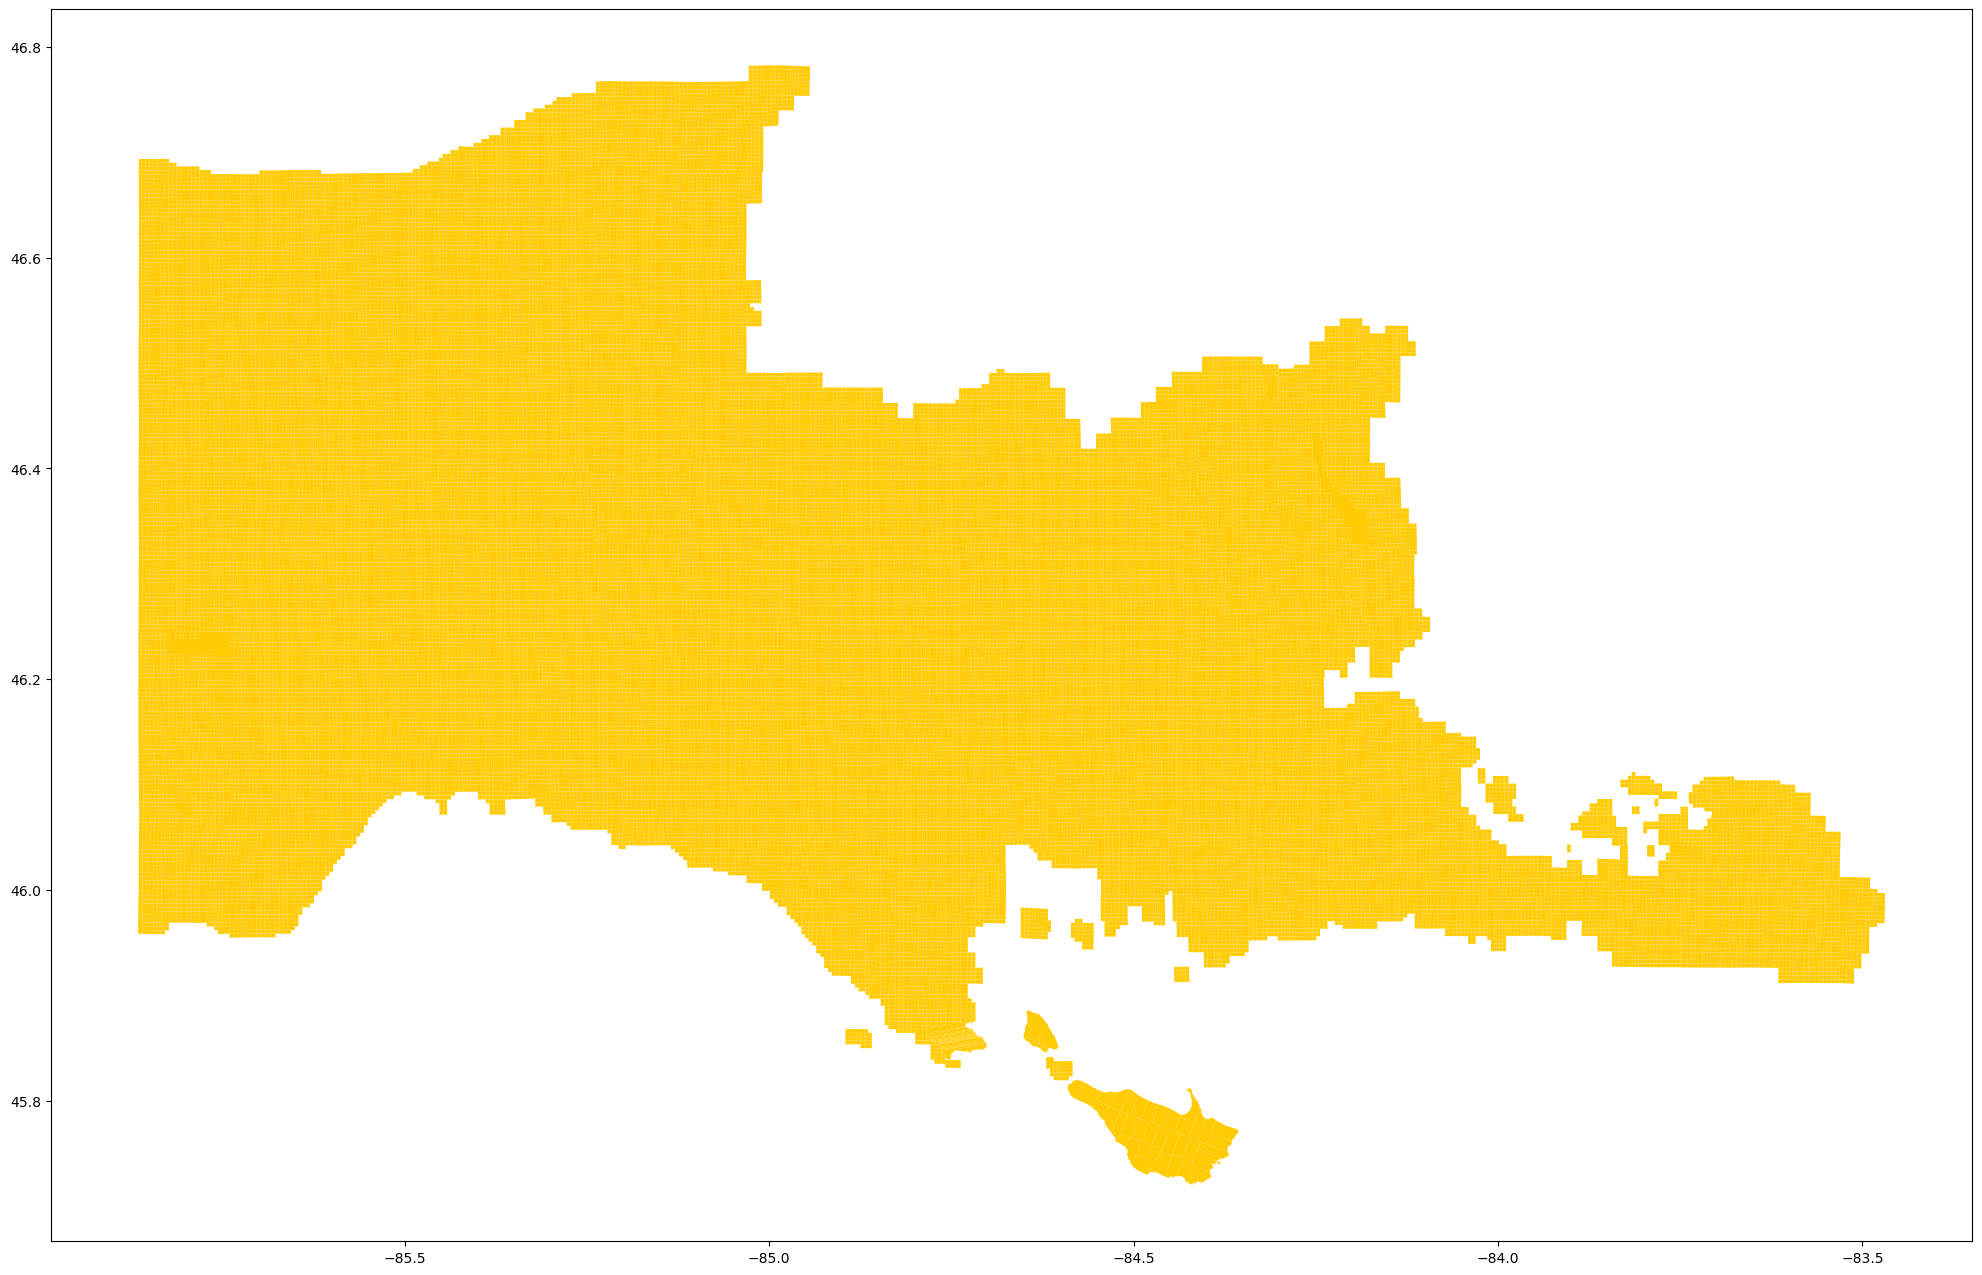

In [10]:
eup_qq_sections.plot(figsize=(32,16), color='#FFCB05')

In [13]:
eup_qq_sections.columns

Index(['OBJECTID', 'GEO_ID', 'COUNTY', 'geometry'], dtype='object')

In [14]:
eup_qq_sections = eup_qq_sections[['OBJECTID', 'GEO_ID', 'COUNTY', 'geometry']]

In [15]:
len(eup_qq_sections)

60701

In [16]:
FCC_EUP_BSL_df = pd.read_csv(data_loc + 'FCC/Fabric_BSL_rel4/FCC_Active_BSL_12312023_rel_4.csv')

/tmp/ipykernel_21749/4026336224.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  FCC_EUP_BSL_df = pd.read_csv(data_loc + 'FCC/Fabric_BSL_rel4/FCC_Active_BSL_12312023_rel_4.csv')


In [17]:
FCC_EUP_BSL_df.columns

Index(['location_id', 'address_primary', 'city', 'state', 'zip', 'zip_suffix',
       'unit_count', 'bsl_flag', 'building_type_code', 'land_use_code',
       'address_confidence_code', 'county_geoid', 'block_geoid', 'h3_9',
       'latitude', 'longitude', 'fcc_rel'],
      dtype='object')

In [18]:
FCC_EUP_BSL_df["county_geoid"].unique()

array([26153, 26095, 26103, 26097, 26003, 26041, 26033])

In [19]:
filter_vals = [26095, 26097, 26033]
filtered_df = FCC_EUP_BSL_df[FCC_EUP_BSL_df['county_geoid'].isin(filter_vals)]

In [20]:
#filtered_df

In [21]:
FCC_EUP_BSL_df = filtered_df.drop(['address_primary', 'city', 'state', 'zip', 'zip_suffix'], axis=1)

In [16]:
FCC_EUP_BSL_df

,location_id,unit_count,bsl_flag,building_type_code,land_use_code,address_confidence_code,county_geoid,block_geoid,h3_9,latitude,longitude,fcc_rel
28,1057525833,1,True,R,4,3,26095,260959601002006,8927636a07bffff,46.350000,-85.502207,12312023
29,1057525834,1,True,R,4,3,26095,260959601001037,8927636a2b7ffff,46.351977,-85.506806,12312023
30,1057525835,1,True,R,4,2,26095,260959601003031,8927636ae43ffff,46.319860,-85.493039,12312023
31,1057525836,1,True,R,4,3,26095,260959602001238,892744a65d7ffff,46.338390,-85.689440,12312023
32,1057525838,2,True,X,4,2,26095,260959601001026,8927636a2b3ffff,46.355138,-85.511579,12312023
...,...,...,...,...,...,...,...,...,...,...,...,...
82670,1453779449,1,True,B,2,3,26033,260339710002017,89276ec84d3ffff,46.211889,-84.304573,12312023
82671,1453779524,1,True,R,1,3,26033,260339710002062,89276eca82fffff,46.159307,-84.220302,12312023
82672,1453779525,1,True,R,1,3,26033,260339710002062,89276eca82fffff,46.158908,-84.220252,12312023
82673,1490273640,1,True,R,6,3,26033,260339803001001,89276334a97ffff,46.248142,-84.455651,12312023


In [22]:
#FCC_USUF_df = pd.read_csv(data_loc + 'FCC/MI_unserved_unfunded_mar2024.csv')
FCC_USUF_df = pd.read_csv(data_loc + 'FCC/BDC/bdc_26_Copper_fixed_broadband_J23_05mar2024.csv')

In [23]:
len(FCC_USUF_df)

2421101

In [24]:
merged_df = pd.merge(FCC_EUP_BSL_df, FCC_USUF_df, how='inner', on='location_id')

In [25]:
len(merged_df)

13614

In [26]:
#Add geomety to merged data Frame
usuf_location_df = gp.GeoDataFrame(
    merged_df, crs=4326, geometry=gp.points_from_xy(merged_df.longitude, merged_df.latitude))

<Axes: >

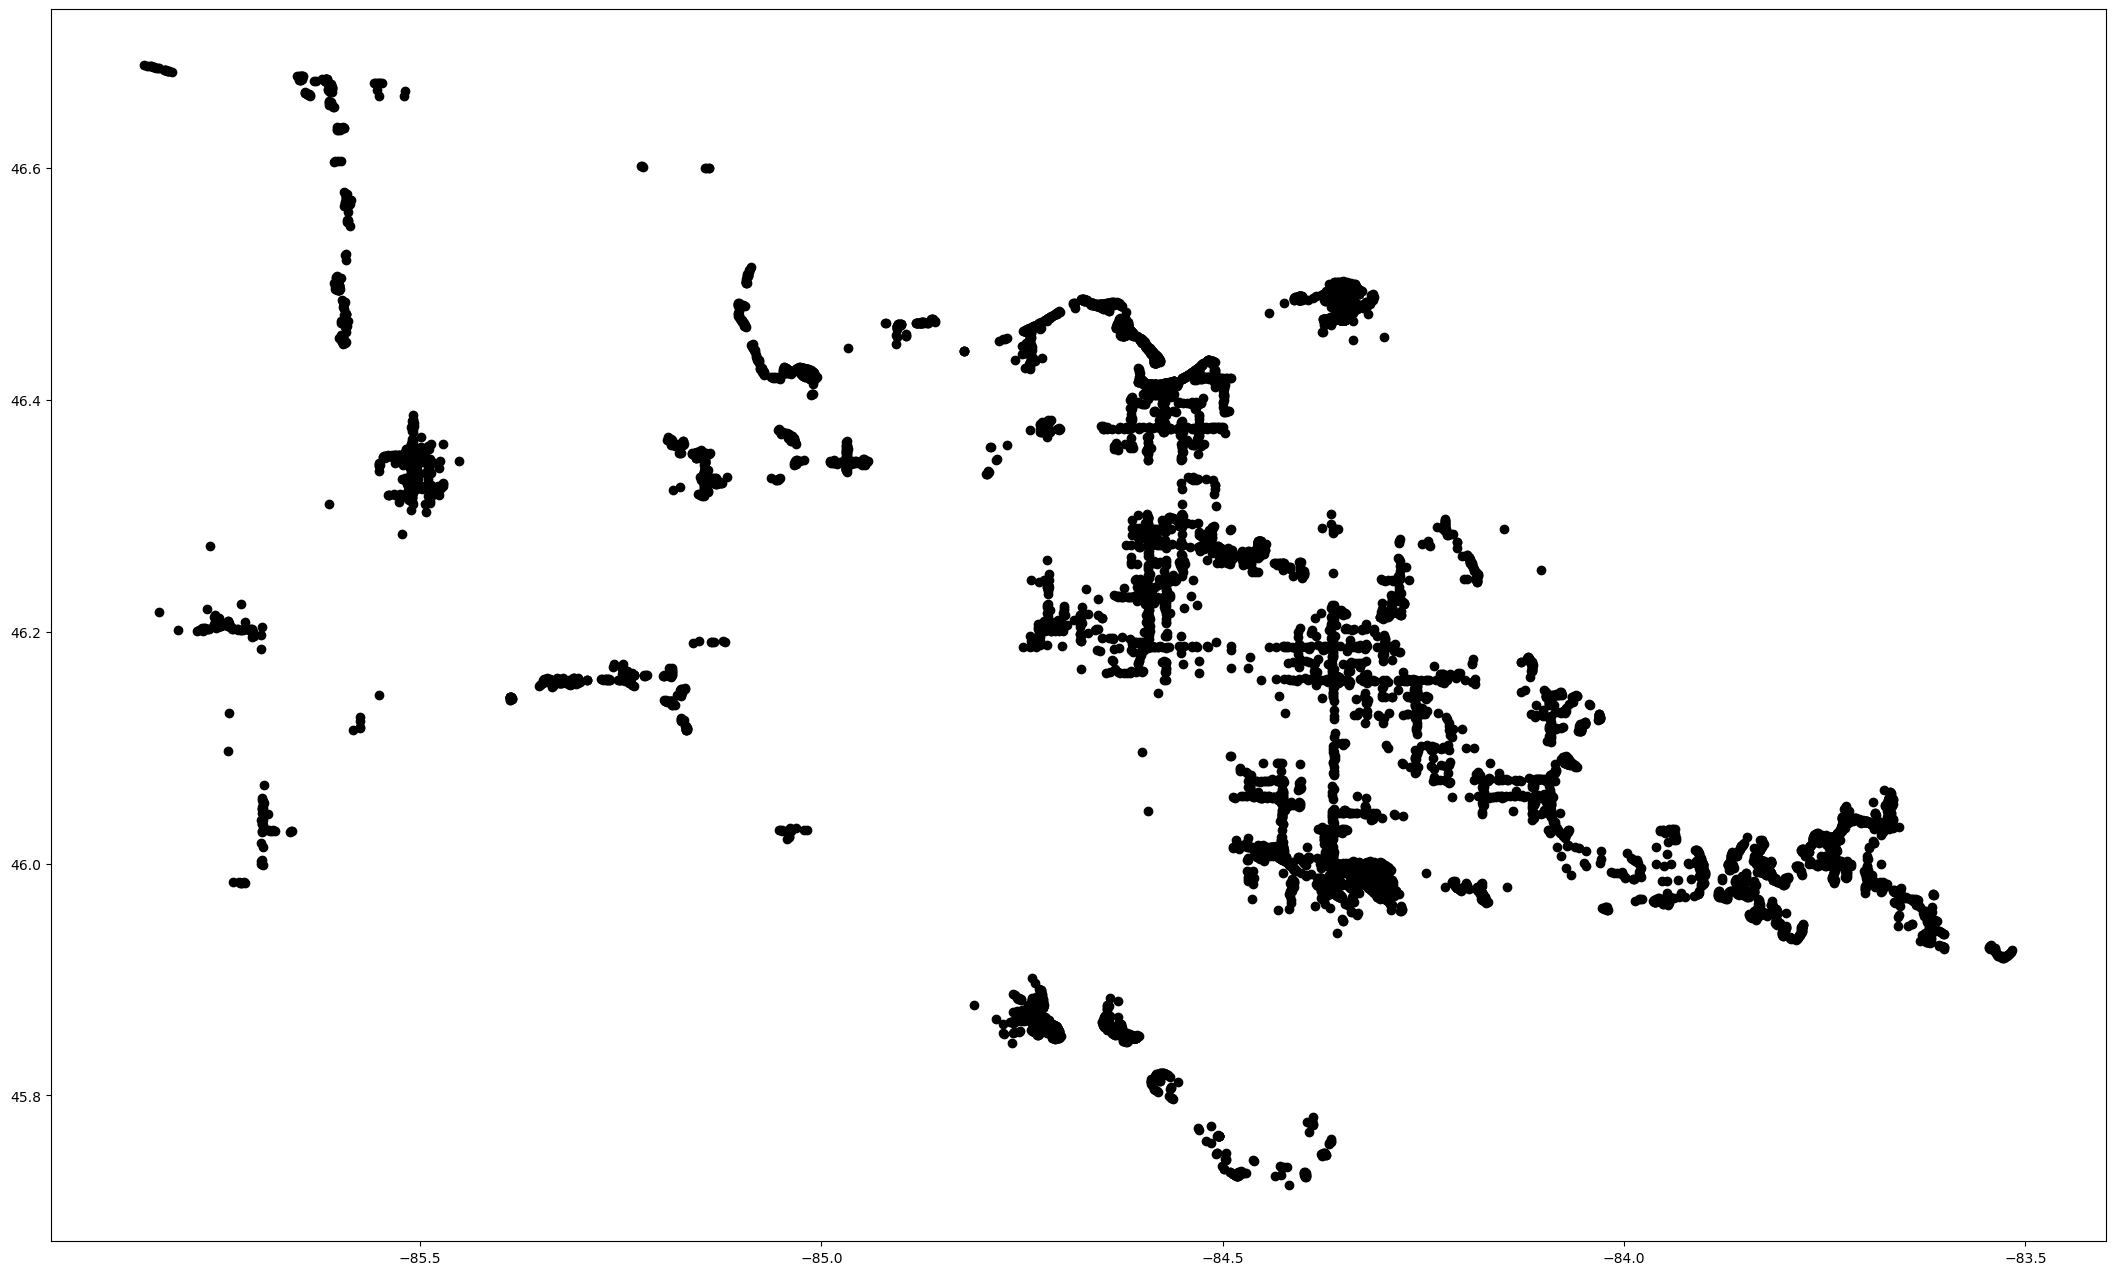

In [27]:
usuf_location_df.plot(figsize=(32,16), color='#000000')

In [38]:
usuf_location_df['low_latency'].unique()

array([1])

In [39]:
usuf_location_df.to_csv(data_loc + 'FCC/BDC/bdc_eup_Copper_fixed_broadband_J23_05mar2024.csv')

In [40]:
USAC_deployment_df = pd.read_csv(data_loc + 'USAC/USAC-EUP-Deployment-0923.csv')

In [41]:
USAC_deployment_gdf = gp.GeoDataFrame(
    USAC_deployment_df, crs=4326, geometry=gp.points_from_xy(USAC_deployment_df.Longitude, USAC_deployment_df.Latitude))

In [42]:
USAC_deployment_gdf.head()


,Unnamed: 0,Fund,Study Area Code,Company Name,Carrier,Latitude,Longitude,Deployment Address,Deployment City,Deployment State,...,Filing Year,Census Block,Locations Deployed,Download/Upload Speed Tier,Technology,Other Technology,Latency,Overlapping Locations,FIPSCODE,geometry
0,0,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.375698,-84.725617,8990 S LILLIAN,BRIMLEY,MI,...,2016,260339706003272,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,77540,POINT (-84.72562 46.37570)
1,1,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.592912,-85.037149,5966 STATE HWY 123,PARADISE,MI,...,2016,260339707001136,1,100 Mbps/25 Mbps,NaN,NaN,NaN,False,86700,POINT (-85.03715 46.59291)
2,2,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.768482,-85.002515,30714 W W CEMETARY RD,PARADISE,MI,...,2016,260339707001001,1,100 Mbps/25 Mbps,NaN,NaN,NaN,False,86700,POINT (-85.00252 46.76848)
3,4,ACAM,310732,LICT CORPORATION,UPPER PENINSULA TEL,46.007051,-83.863520,34980 S DIX POINT RD,DRUMMOND ISLAND,MI,...,2016,260339711001027,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,23080,POINT (-83.86352 46.00705)
4,5,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.361198,-84.536272,8348 W 10 MILE RD,BRIMLEY,MI,...,2016,260339708001055,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,77540,POINT (-84.53627 46.36120)


In [43]:
USAC_deployment_gdf['Fund'].unique()

array(['ACAM', 'CAF II'], dtype=object)

In [44]:
eup_counties = gp.read_file(data_loc + 'MI/EUPCounties.shp.zip')
eup_towns = gp.read_file(data_loc + 'MI/EUPTowns.shp.zip')
#eup_towns = eup_towns[['FIPSCODE', 'geometry']]

<Axes: >

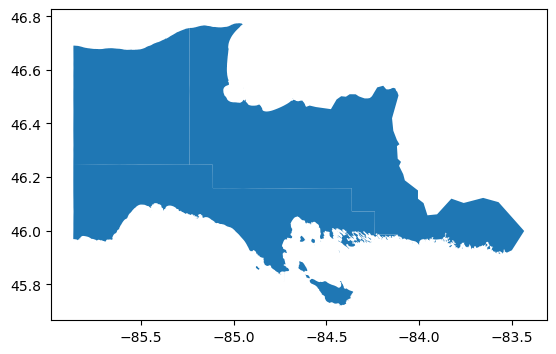

In [45]:
eup_counties.plot()

In [46]:
#eup_towns eup_qq_sections
# joined_df = gp.sjoin(eup_qq_sections, eup_towns, how='inner', predicate ='intersects')

In [47]:
#joined_df.columns

In [48]:
#joined_df['NAME'].unique().tolist()

In [49]:
eup_towns

,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTAre,ShapeSTLen,geometry
0,156,86700,86700,Whitefish,Whitefish Township,Township,636.691918,245.826995,157328.305068,20,portrait,upper,6.366919e+08,127804.341492,"POLYGON ((-84.98926 46.47816, -84.98928 46.477..."
1,157,77020,77020,Sugar Island,Sugar Island Township,Township,198.406177,76.604702,49026.706184,20,portrait,upper,1.984062e+08,68523.322539,"POLYGON ((-84.11942 46.31516, -84.12186 46.316..."
2,158,06070,6070,Bay Mills,Bay Mills Township,Township,201.455193,77.781928,49780.126269,20,landscape,upper,2.014552e+08,100988.905151,"MULTIPOLYGON (((-84.47575 46.45288, -84.47943 ..."
3,159,74620,74620,Soo,Soo Township,Township,175.633099,67.812007,43399.416538,20,landscape,upper,1.756331e+08,99898.197083,"POLYGON ((-84.11942 46.31516, -84.11973 46.315..."
4,160,77540,77540,Superior,Superior Township,Township,271.049014,104.652129,66976.948740,20,landscape,upper,2.710490e+08,79311.792884,"POLYGON ((-84.48895 46.41883, -84.48893 46.417..."
5,161,11280,11280,Bruce,Bruce Township,Township,234.703035,90.618932,57995.758467,20,portrait,upper,2.347030e+08,69213.559894,"POLYGON ((-84.17977 46.24512, -84.18376 46.245..."
6,162,19540,19540,Dafter,Dafter Township,Township,124.101187,47.915516,30665.740849,20,portrait,upper,1.241012e+08,51596.553276,"POLYGON ((-84.38423 46.30256, -84.39972 46.302..."
7,163,15560,15560,Chippewa,Chippewa Township,Township,247.221189,95.452197,61089.028498,20,landscape,upper,2.472212e+08,71065.847617,"POLYGON ((-84.86445 46.41838, -84.86443 46.416..."
8,164,39860,39860,Hulbert,Hulbert Township,Township,185.809868,71.741262,45914.123962,20,portrait,upper,1.858099e+08,57791.411043,"POLYGON ((-85.11459 46.41893, -85.11458 46.411..."
9,165,43480,43480,Kinross,Kinross Township,Township,313.072212,120.877302,77360.995337,20,landscape,upper,3.130722e+08,112747.999289,"POLYGON ((-84.38423 46.30256, -84.38396 46.296..."


In [50]:
test_df = gp.sjoin(USAC_deployment_gdf, eup_towns, how="inner", predicate='within')

In [51]:
test_df.columns

Index(['Unnamed: 0', 'Fund', 'Study Area Code', 'Company Name', 'Carrier',
       'Latitude', 'Longitude', 'Deployment Address', 'Deployment City',
       'Deployment State', 'Deployment ZIP Code', 'SAC Primary State',
       'Deployment Date', 'Filing Year', 'Census Block', 'Locations Deployed',
       'Download/Upload Speed Tier', 'Technology', 'Other Technology',
       'Latency', 'Overlapping Locations', 'FIPSCODE_left', 'geometry',
       'index_right', 'OBJECTID', 'FIPSCODE_right', 'FIPSNUM', 'NAME', 'LABEL',
       'TYPE', 'SQKM', 'SQMILES', 'ACRES', 'VER', 'LAYOUT', 'PENINSULA',
       'ShapeSTAre', 'ShapeSTLen'],
      dtype='object')

In [52]:
USAC_deployment_gdf = test_df[['Fund', 'Study Area Code', 'Company Name', 'Carrier', 'Latitude',
                                'Longitude', 'Deployment Address', 'Deployment City',
                                'Deployment State', 'Deployment ZIP Code', 'SAC Primary State',
                                'Deployment Date', 'Filing Year', 'Census Block', 'Locations Deployed',
                                'Download/Upload Speed Tier', 'Technology', 'Other Technology',
                                'Latency', 'Overlapping Locations', 'FIPSCODE', 'geometry']]


KeyError: "['FIPSCODE'] not in index"

In [56]:
USAC_deployment_gdf['Carrier'].unique()

array(['HIAWATHA TEL CO', 'UPPER PENINSULA TEL', 'CHATHAM TEL CO - MI',
       'BRIGHTSPEED OF MICHIGAN, INC', 'MICHIGAN BELL TEL CO'],
      dtype=object)

In [57]:
USAC_deployment_gdf['Download/Upload Speed Tier'].unique()

array(['10 Mbps/1 Mbps', '100 Mbps/25 Mbps', '25 Mbps/3 Mbps',
       '4 Mbps/1 Mbps', '1 Gbps/500 Mbps'], dtype=object)

<Axes: >

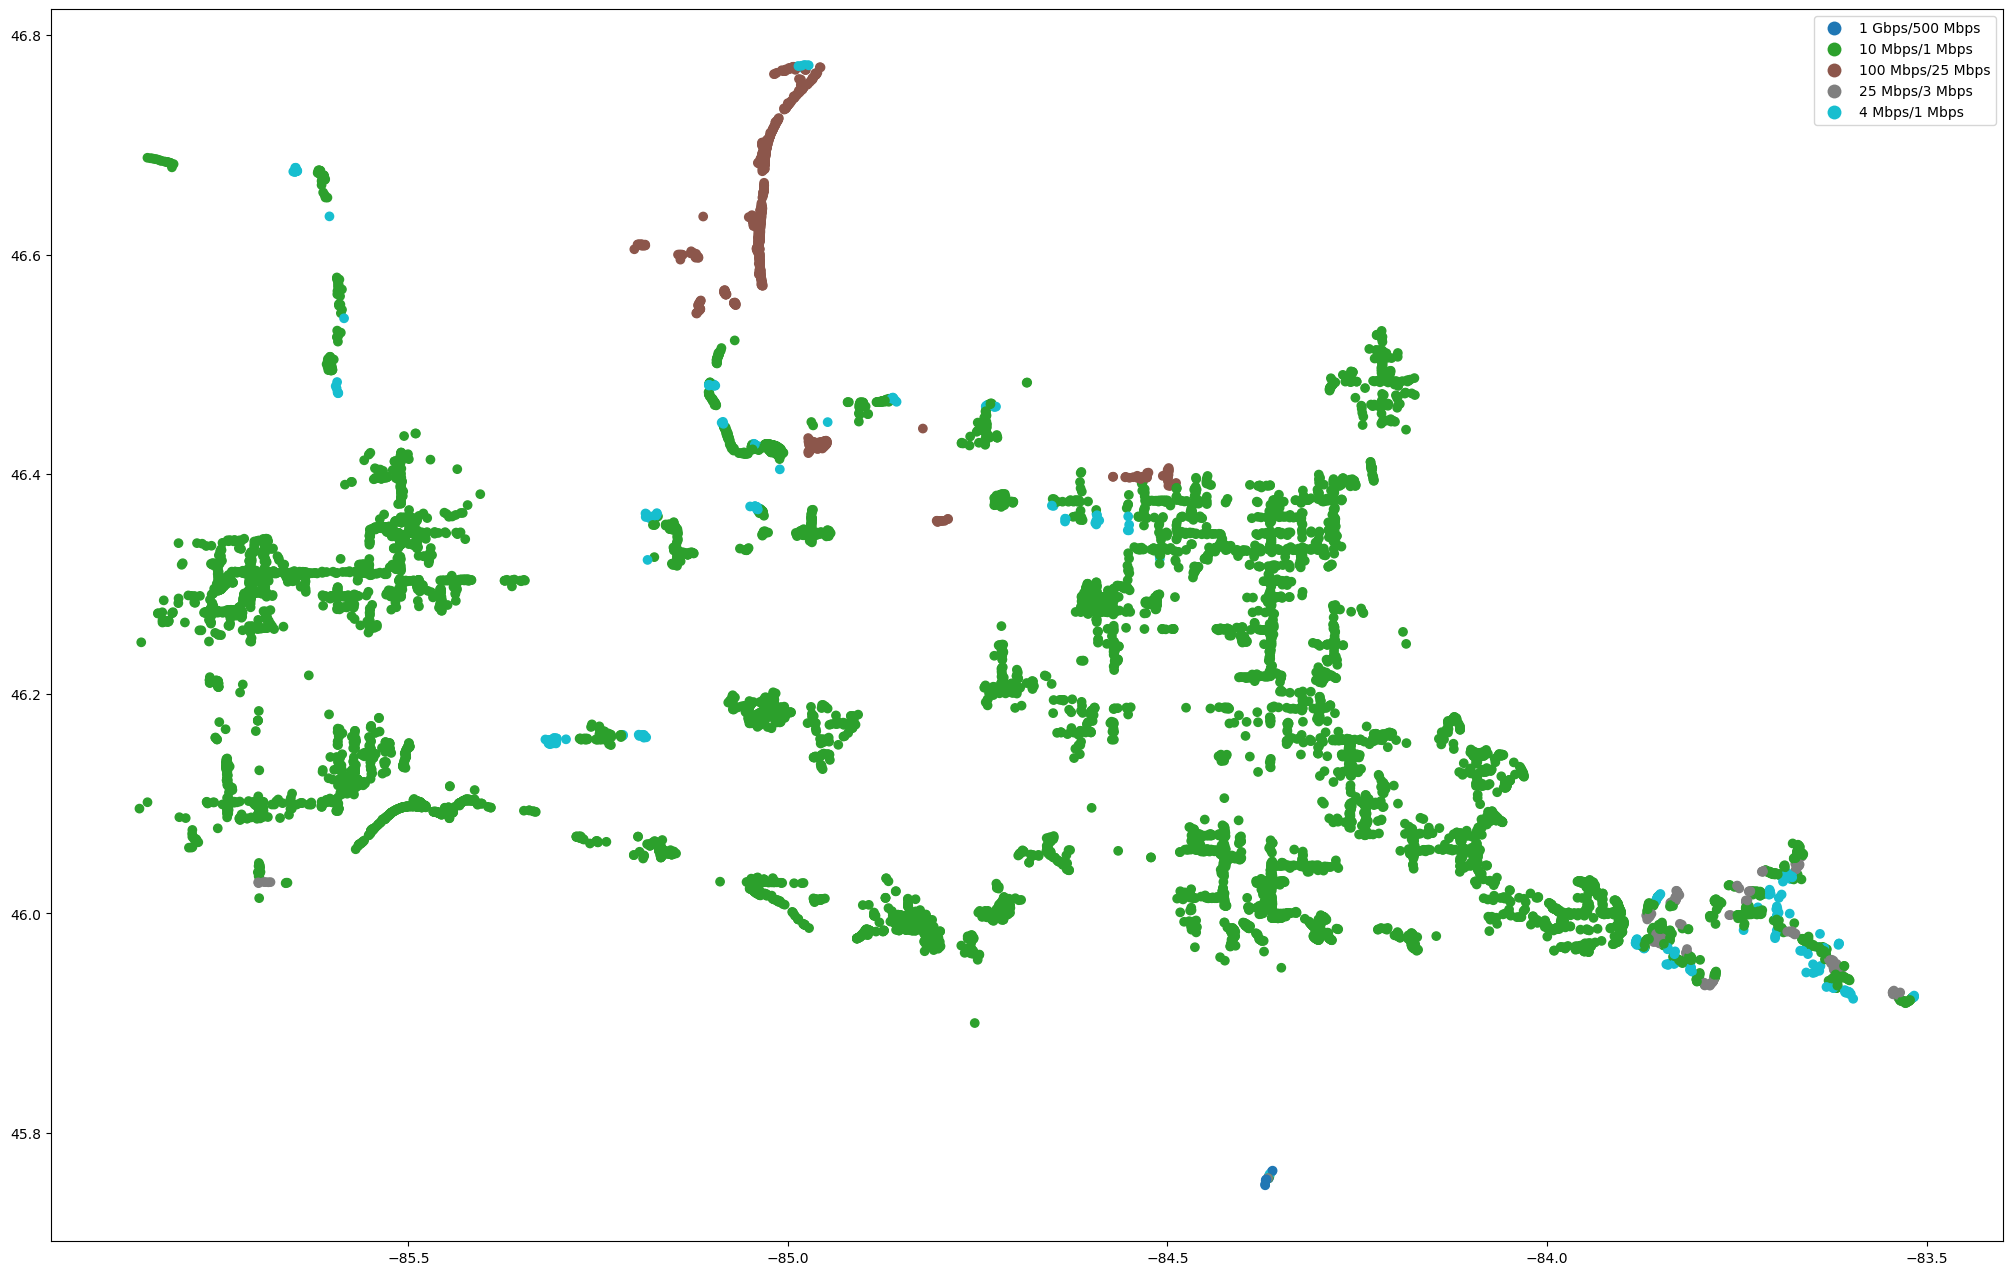

In [85]:
USAC_deployment_gdf.plot(USAC_deployment_gdf['Download/Upload Speed Tier'], figsize=(32,16), legend=True)

In [59]:
USAC_deployment_gdf.to_csv(data_loc + 'USAC/USAC-EUP-Deployment-0923.csv')

In [84]:
USAC_deployment_gdf

,Fund,Study Area Code,Company Name,Carrier,Latitude,Longitude,Deployment Address,Deployment City,Deployment State,Deployment ZIP Code,...,Filing Year,Census Block,Locations Deployed,Download/Upload Speed Tier,Technology,Other Technology,Latency,Overlapping Locations,FIPSCODE,geometry
0,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.375698,-84.725617,8990 S LILLIAN,BRIMLEY,MI,49715,...,2016,260339706003272,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,77540,POINT (-84.72562 46.37570)
1,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.592912,-85.037149,5966 STATE HWY 123,PARADISE,MI,49768,...,2016,260339707001136,1,100 Mbps/25 Mbps,NaN,NaN,NaN,False,86700,POINT (-85.03715 46.59291)
2,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.768482,-85.002515,30714 W W CEMETARY RD,PARADISE,MI,49768,...,2016,260339707001001,1,100 Mbps/25 Mbps,NaN,NaN,NaN,False,86700,POINT (-85.00252 46.76848)
4,ACAM,310732,LICT CORPORATION,UPPER PENINSULA TEL,46.007051,-83.863520,34980 S DIX POINT RD,DRUMMOND ISLAND,MI,49726,...,2016,260339711001027,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,23080,POINT (-83.86352 46.00705)
5,ACAM,310713,"HIAWATHA COMMUNICATIONS, INC.",HIAWATHA TEL CO,46.361198,-84.536272,8348 W 10 MILE RD,BRIMLEY,MI,49715,...,2016,260339708001055,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,77540,POINT (-84.53627 46.36120)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11190,CAF II,315090,AT&T INC.,MICHIGAN BELL TEL CO,46.419314,-85.509569,13010 STATE HIGHWAY M123,NEWBERRY,MI,49868,...,2019,260959601004110,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,50440,POINT (-85.50957 46.41931)
11191,CAF II,315090,AT&T INC.,MICHIGAN BELL TEL CO,46.448893,-84.206633,7515 E 4 MILE RD,SAULT SAINTE MARIE,MI,49783,...,2020,260339701001038,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,77020,POINT (-84.20663 46.44889)
11192,CAF II,310702,CONNECT PARENT CORPORATION,"BRIGHTSPEED OF MICHIGAN, INC",46.007197,-84.362446,542 N M 129,CEDARVILLE,MI,49719,...,2020,260979501002001,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,16060,POINT (-84.36245 46.00720)
11193,CAF II,315090,AT&T INC.,MICHIGAN BELL TEL CO,46.094427,-85.695716,6113 2ND ST,GOULD CITY,MI,49838,...,2020,260979503001157,1,10 Mbps/1 Mbps,NaN,NaN,NaN,False,57640,POINT (-85.69572 46.09443)


In [60]:
eup_towns

,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTAre,ShapeSTLen,geometry
0,156,86700,86700,Whitefish,Whitefish Township,Township,636.691918,245.826995,157328.305068,20,portrait,upper,6.366919e+08,127804.341492,"POLYGON ((-84.98926 46.47816, -84.98928 46.477..."
1,157,77020,77020,Sugar Island,Sugar Island Township,Township,198.406177,76.604702,49026.706184,20,portrait,upper,1.984062e+08,68523.322539,"POLYGON ((-84.11942 46.31516, -84.12186 46.316..."
2,158,06070,6070,Bay Mills,Bay Mills Township,Township,201.455193,77.781928,49780.126269,20,landscape,upper,2.014552e+08,100988.905151,"MULTIPOLYGON (((-84.47575 46.45288, -84.47943 ..."
3,159,74620,74620,Soo,Soo Township,Township,175.633099,67.812007,43399.416538,20,landscape,upper,1.756331e+08,99898.197083,"POLYGON ((-84.11942 46.31516, -84.11973 46.315..."
4,160,77540,77540,Superior,Superior Township,Township,271.049014,104.652129,66976.948740,20,landscape,upper,2.710490e+08,79311.792884,"POLYGON ((-84.48895 46.41883, -84.48893 46.417..."
5,161,11280,11280,Bruce,Bruce Township,Township,234.703035,90.618932,57995.758467,20,portrait,upper,2.347030e+08,69213.559894,"POLYGON ((-84.17977 46.24512, -84.18376 46.245..."
6,162,19540,19540,Dafter,Dafter Township,Township,124.101187,47.915516,30665.740849,20,portrait,upper,1.241012e+08,51596.553276,"POLYGON ((-84.38423 46.30256, -84.39972 46.302..."
7,163,15560,15560,Chippewa,Chippewa Township,Township,247.221189,95.452197,61089.028498,20,landscape,upper,2.472212e+08,71065.847617,"POLYGON ((-84.86445 46.41838, -84.86443 46.416..."
8,164,39860,39860,Hulbert,Hulbert Township,Township,185.809868,71.741262,45914.123962,20,portrait,upper,1.858099e+08,57791.411043,"POLYGON ((-85.11459 46.41893, -85.11458 46.411..."
9,165,43480,43480,Kinross,Kinross Township,Township,313.072212,120.877302,77360.995337,20,landscape,upper,3.130722e+08,112747.999289,"POLYGON ((-84.38423 46.30256, -84.38396 46.296..."


<Axes: >

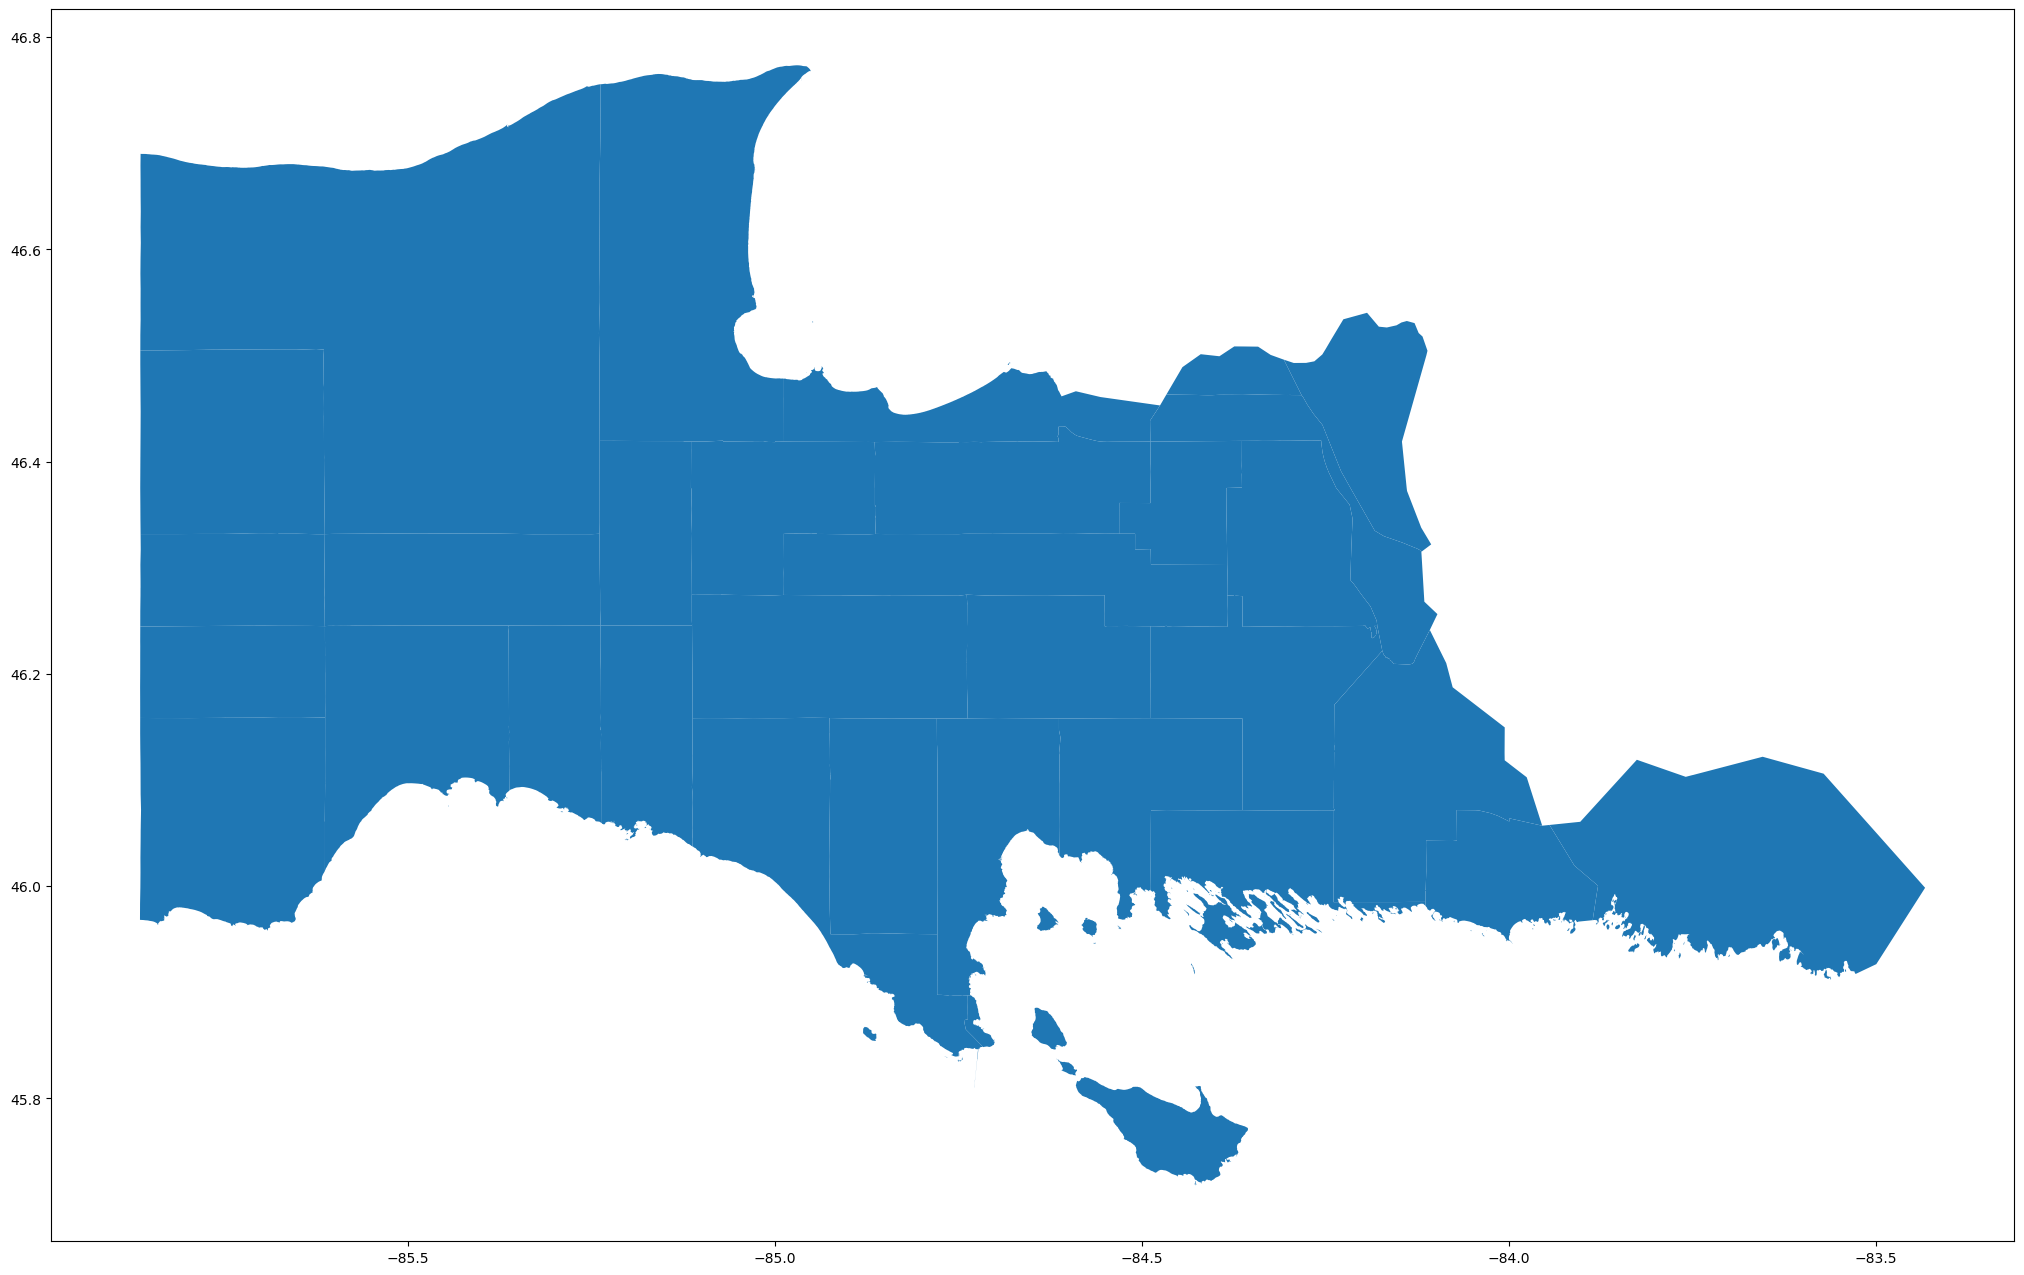

In [61]:
eup_towns.plot(figsize=(32,16))

In [102]:
eup_towns.to_file(data_loc + 'MI/EUPTowns.shp.zip', driver='ESRI Shapefile')

In [81]:
eup_counties

,FIPSCODE,geometry
0,033,"MULTIPOLYGON (((-83.93101 46.05865, -83.92995 ..."
1,095,"POLYGON ((-85.86468 46.28084, -85.86462 46.281..."
2,097,"MULTIPOLYGON (((-84.36273 45.99577, -84.36275 ..."


In [80]:
import requests

def query_digital_equity_data(api_key, state, county):
    """
    Queries digital equity data from the US Census ACS API.

    Args:
        api_key (str): Your Census API key.
        state (str): State code (e.g., '26' for Michigan).
        county (str): County (e.g., '095').

    Returns:
        dataframe: Digital equity data (e.g., internet access, computer ownership, etc.).
    """
    base_url = "https://api.census.gov/data/2022/acs/acs5"
    variables = {
        "NAME": "name",
        "B01001_001E": "B01001_001E",
        "B28002_001E": "total_households",
        "B28002_002E": "with_computer",
        "B28002_003E": "with_internet",
        "B28002_004E": "with_broadband",        
    }

    params = {
        "get": ",".join(variables.keys()),
        "for": "county subdivision:*",
        "in": "state:" + state + " county:" + county,
        "key": api_key,
    }
    #print(params)

    response = requests.get(base_url, params=params)
    #print(response)
    data = response.json()
    data = pd.DataFrame(data)
    data.columns = data.iloc[0]
    data = data[~data["county subdivision"].isin(['00000', 'county subdivision'])]
    data.rename(columns={'county subdivision': 'FIPSCODE'},inplace=True)
    data = data.reset_index(drop=True)

    if "error" in data:
        raise Exception(f"Error fetching data: {data['error'][0]}")

    return data


In [72]:
us_census_api_key = '7cc77ebf07d9da06e072f0d66416e2386dba588d'

if __name__ == "__main__":
    api_key = us_census_api_key
    state_code = "26"
    county = "033,095,097"

    try:
        digital_equity_data = query_digital_equity_data(api_key, state_code, county)
        print("Digital Equity Data:")
        # for key, value in digital_equity_data.items():
        #     print(f"{key}: {value}")
        #print(digital_equity_data)
    except Exception as e:
        print(f"Error: {e}")


Digital Equity Data:


In [75]:
#digital_equity_data = digital_equity_data

#The metrics pulled from census still need some work.
digital_equity_data.to_json(data_loc + 'census_eup_towns.json')

In [76]:
data4 = pd.read_json(data_loc + 'census_eup_towns.json')

In [78]:
data4

,NAME,B01001_001E,B28002_001E,B28002_002E,B28002_003E,B28002_004E,state,county,FIPSCODE
0,"Bay Mills township, Chippewa County, Michigan",1821,736,656,0,656,26,33,6070
1,"Bruce township, Chippewa County, Michigan",1982,785,708,0,708,26,33,11280
2,"Chippewa township, Chippewa County, Michigan",298,119,90,1,89,26,33,15560
3,"Dafter township, Chippewa County, Michigan",1490,478,382,0,382,26,33,19540
4,"Detour township, Chippewa County, Michigan",632,306,257,2,255,26,33,21770
5,"Drummond township, Chippewa County, Michigan",1001,541,486,0,486,26,33,23080
6,"Hulbert township, Chippewa County, Michigan",161,82,68,0,68,26,33,39860
7,"Kinross charter township, Chippewa County, Mic...",7069,1418,1299,0,1299,26,33,43480
8,"Pickford township, Chippewa County, Michigan",1511,592,524,3,521,26,33,63980
9,"Raber township, Chippewa County, Michigan",556,274,196,14,182,26,33,66760


In [180]:
data2 = requests.get("https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=county%20subdivision:*&in=state:26&in=county:097,095,033&key=" + us_census_api_key)

In [181]:
data2

<Response [200]>

In [182]:
data3 = data2.json()

In [183]:
data_df = pd.DataFrame(data3)
data_df

,0,1,2,3,4
0,NAME,B01001_001E,state,county,county subdivision
1,"County subdivisions not defined, Chippewa Coun...",0,26,033,00000
2,"Bay Mills township, Chippewa County, Michigan",1821,26,033,06070
3,"Bruce township, Chippewa County, Michigan",1982,26,033,11280
4,"Chippewa township, Chippewa County, Michigan",298,26,033,15560
5,"Dafter township, Chippewa County, Michigan",1490,26,033,19540
6,"Detour township, Chippewa County, Michigan",632,26,033,21770
7,"Drummond township, Chippewa County, Michigan",1001,26,033,23080
8,"Hulbert township, Chippewa County, Michigan",161,26,033,39860
9,"Kinross charter township, Chippewa County, Mic...",7069,26,033,43480


Background information about the **Margin of Error (MOE)** in **US Census data** with reference links included:

---

## Margin of Error (MOE) in US Census Data

The **Margin of Error (MOE)** in **US Census data** is a measure of the **possible variation** of an estimate around the actual population     ns:

#Estimates and Sampling:

  - The **American Community Survey (ACS)** provides estimates based on a **sample** of the population.
  - Different samples would yield different estimates of the actual population value.
  - The MOE accounts for this va##   iability.

#Certainty at a Given Confidence Level:

  - Data users can be **certain** at a given **confidence level** that the estimate and the actual population value differ by no more than the value of the MOE.
  - The confidence level is typically **90%**, but other levels (such as 95% or 99%) ca#    also be used.

#Interpreting MOE:

  - If an estimate is **50,000** with an MOE of **2,000**, it means that we are **90% confident** that the actual population value lies between **48,000** and **52,000**.
  - The MOE provides a **range** within which the true#   value likely falls.

#Statistical Significance:

  - When comparing estimates, we use the MOE to test for **statistical significance**.
  - If the difference between two estimates is **greater than the MOE**, they are considered **statistically different**.

In summary, the MOE ensures that ACS estimates are not exact figures but rather a **range of possible values** around the population value, accounting for sampling variability.

---

**References**:
1. [US Census Bureau - Understanding and Using American Community Survey Data: Margin of Error](https://www.census.gov/programs-surveys/acs/guidance/handbooks/general.html)
2. [American Community Survey (ACS) - Accuracy of the Data](https://www.census.gov/programs-ml) ys/acs/guidance/accuracy.html) 